In [1]:
import pandas as pd
import numpy as np
import pdfplumber
import concurrent.futures
from pdfplumber.page import Page, Table
from typing import Optional
from tqdm.auto import tqdm
import math
import re
import os

In [2]:
tqdm.pandas()

## Scrape PDFs from 2009 to 2014

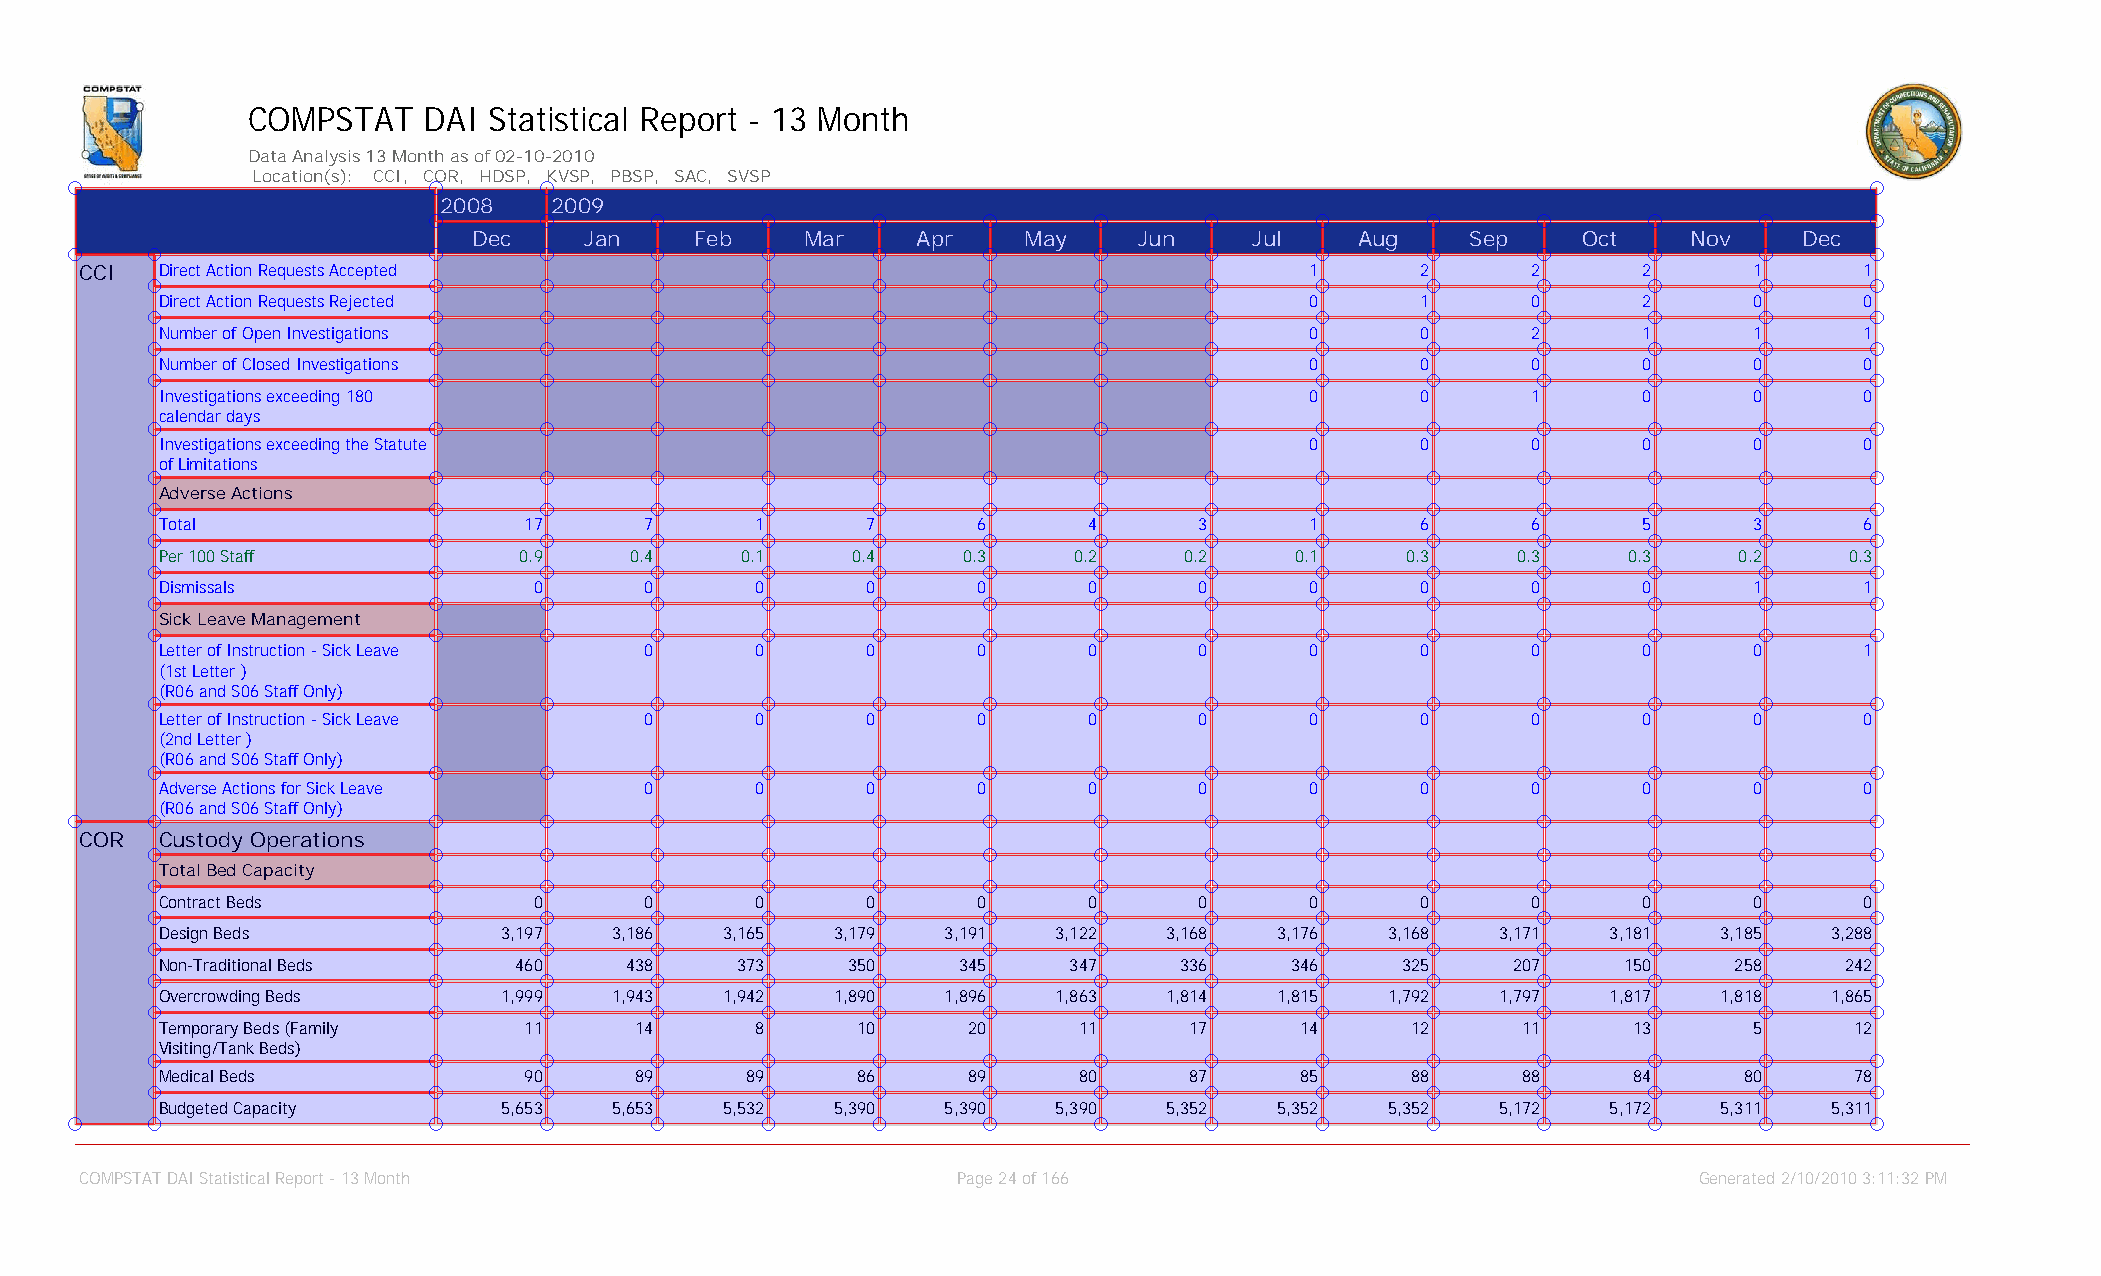

In [3]:
#Try one sample to check table finder from PDFPlumber https://github.com/jsvine/pdfplumber
pdf_name = "pdfs-2009-to-2019/2009_12_DAI_High_Security.pdf"

pdf  = pdfplumber.open(pdf_name)
page = pdf.pages[23]
image = page.to_image(resolution=150)
image.reset().debug_tablefinder()

In [4]:
#Function to extract background color of a cell. 
#Thanks to https://stackoverflow.com/a/73759921/838158

def to_bbox(rect: dict) -> tuple[float, float, float, float]:
    return (rect["x0"], rect["top"], rect["x1"], rect["bottom"])

def is_included(cell_box: tuple[float, float, float, float], rect_box: tuple[float, float, float, float]):
    c_left, c_top, c_right, c_bottom = tuple([round(j) for j in cell_box])
    r_left, r_top, r_right, r_bottom = tuple([round(j) for j in rect_box])
    #return c_left >= r_left and c_top >= r_top and c_right <= r_right and c_bottom <= r_bottom
    return math.isclose(c_left, r_left, abs_tol=1) and math.isclose(c_top, r_top, abs_tol=1) and math.isclose(c_right, r_right, abs_tol=1) and math.isclose(c_bottom, r_bottom, abs_tol=1)

def find_rect_for_cell(cell: tuple[float, float, float, float], rects: list[dict]) -> Optional[dict]:
    return next((r for r in rects if is_included(cell, to_bbox(r))), None)


def get_cell_color(cell: tuple[float, float, float, float], page: Page) -> tuple[float, float, float]:
    rect = find_rect_for_cell(cell, page.rects) if cell else None
    return rect["non_stroking_color"] if (rect and "non_stroking_color" in rect) else (255,255,255)

#print(get_cell_color(tables[0].rows[0].cells[0], page))


In [5]:
#list of pdf files in the pdfs-2009-2019 folder
pdf_files = sorted((f for f in os.listdir("pdfs-2009-to-2019") if not f.startswith(".")), key=str.lower)

# DataFrame to hold everything
df = pd.DataFrame()

# Clearn cell data
def parse_value(txt):
    cid     = re.sub(r'\(cid\:\d+\)', ' ', txt) #remove (cid:13) type codes
    comma   = re.sub(r',', '', cid)             #remove comma separators
    newLine = re.sub(r'\n', '', comma)          #remove new lines
    return newLine 


def extract_pdf(filename):

    topcategory         = '' #some rows are top categories, like "Custody Operations"
    subcategory         = '' #some rows are sub categories, like "Total Bed Capacity"
    current_institution = '' #some institutions change mid-page, so we identify in loop when this happens

    #open PDF
    pdf = pdfplumber.open("pdfs-2009-to-2019/" + filename) #open current pdf

    #set up progress bars for seeing which page we're processing
    pbar2 = tqdm(total=len(pdf.pages), position=1, leave=False)

    page_df = pd.DataFrame()
    
    for ipage,page in enumerate(pdf.pages):
    
        pbar2.update(1)
        pbar2.set_description("Processing Page: %s out of %s" % (ipage+1, len(pdf.pages)))
            
        table_text = page.extract_table()
        table_obj  = page.find_table()
        
        if table_text is not None:
        
            #Loop through each row starting on row two, after the year headers [0] and month headers [1]
            for r,row in enumerate(table_text[2:], start=2):
        
                #get the current metric label for this row
                metric_title = parse_value(row[1])
    
                #Change the current institution, so reset sub category and top category
                if (row[0] != None) and (row[0] != current_institution):
                    current_institution = row[0]
                    topcategory = '' #we changed institutions, so blank out topcategory
                    subcategory = '' #we changed institutions, so blank out subcategory
                    if all(val=='' for val in row[2:]):
                        metric_title = '' #we changed institutions, and this row has no values, so blank out metric title
        
                #this row is all blank and row header background color matches a top-level category, like "Custody Operations"
                if (all(val=='' for val in row[2:]) and get_cell_color(table_obj.rows[r].cells[1], page) == (0.827, 0.827, 0.827)):
                    topcategory = row[1]
                    continue
                    
                #This row is all blank and row header is a colored cell. Create a new sub category
                if (all(val=='' for val in row[2:]) and get_cell_color(table_obj.rows[r].cells[1], page) != (255,255,255)):
                    subcategory = row[1] #if all values are empty, make a new subcategory
                    continue
                        
                row_builder = { 'Institution':current_institution, 'Year': table_text[0][3], 'Top Category':topcategory, 'Subcategory':subcategory, 'Metric Title': metric_title }
                
                #Skip Dec column from previous month, for each month Jan-Dec extract value as dict connected to that month
                for i, month in enumerate(table_text[1][3:]):
                    row_builder[month] = parse_value(row[i + 3])

                page_df = pd.concat([page_df, pd.DataFrame([row_builder])], ignore_index=True)
                
    pbar2.close()
    return page_df
        

def main():
    df_document = pd.DataFrame()
    pbar1 = tqdm(total=len(pdf_files), position=0)
    for pdfs in pdf_files:
        pbar1.update(1)
        df_document = pd.concat([df_document, extract_pdf(pdfs)], ignore_index=True)

    return df_document

if __name__ == '__main__':
    df = pd.concat([df, main()], ignore_index=True)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

In [6]:
df

,Institution,Year,Top Category,Subcategory,Metric Title,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,CCWF,2009,Custody Operations,Total Bed Capacity,Contract Beds,0,0,0,0,0,0,0,0,0,0,0,0
1,CCWF,2009,Custody Operations,Total Bed Capacity,Design Beds,1916,1953,1945,1961,1969,1999,2007,1986,1966,2006,1969,1993
2,CCWF,2009,Custody Operations,Total Bed Capacity,Non-Traditional Beds,265,62,72,72,36,0,0,72,67,0,0,0
3,CCWF,2009,Custody Operations,Total Bed Capacity,Overcrowding Beds,1801,1886,1851,1884,1894,1897,1927,1919,1884,1926,1902,1920
4,CCWF,2009,Custody Operations,Total Bed Capacity,Temporary Beds (FamilyVisiting/Tank Beds),0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201282,SVSP,2019,Surplus/Deficit,Adverse Actions,Per 100 Staff,0.44,0.09,0.51,0.00,0.00,0.26,0.69,0.09,0.35,0.34,0.60,0.51
201283,SVSP,2019,Surplus/Deficit,Adverse Actions,Dismissals (Non-Medical),0,1,1,0,0,0,0,0,0,0,0,0
201284,SVSP,2019,Surplus/Deficit,Adverse Actions,Adverse Actions Total (Medical),2,1,1,1,0,0,0,0,0,1,0,0
201285,SVSP,2019,Surplus/Deficit,Adverse Actions,Per 100 Staff,0.17,0.09,0.09,0.08,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00


In [7]:
df.to_csv("finished-csvs/finished-2009-2019-everything.csv", encoding="utf-8", index=False)